<a href="https://colab.research.google.com/github/happyrabbit/IntroDataScience/blob/master/Python/Regularization_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ridge Regression

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge, Lasso
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet

In [2]:
# load data
sim_dat = pd.read_csv("http://bit.ly/2P5gTw4")
sim_dat.head()

,age,gender,income,house,store_exp,online_exp,store_trans,online_trans,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,segment
0,57,Female,120963.400958,Yes,529.134363,303.512475,2,2,4,2,1,2,1,4,1,4,2,4,Price
1,63,Female,122008.104950,Yes,478.005781,109.529710,4,2,4,1,1,2,1,4,1,4,1,4,Price
2,59,Male,114202.295294,Yes,490.810731,279.249582,7,2,5,2,1,2,1,4,1,4,1,4,Price
3,60,Male,113616.337078,Yes,347.809004,141.669752,10,2,5,2,1,3,1,4,1,4,2,4,Price
4,51,Male,124252.552787,Yes,379.625940,112.237177,4,4,4,1,1,3,1,4,1,4,2,4,Price


Let’s use the 10 survey questions to predict the total purchase amount (sum of online and store purchase).

In [3]:
sim_dat = sim_dat[sim_dat.store_exp >0] 
sim_dat = sim_dat[sim_dat.online_exp > 0]
# get predictors
trainx = sim_dat.filter(regex = "^Q")
# get response
# total expense = in store expense + online expense
trainy =  sim_dat.store_exp + sim_dat.online_exp

The `Ridge()` function has an `alpha` argument ( $\lambda$ in the text) that is used to tune the model. We'll generate an array of `alpha` values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. Since ridge regression adds the penalty parameter $\lambda$ in front of the sum of squares of the parameters, the scale of the parameters matters. So here it is better to center and scale the predictors. 

In [4]:
alphas = np.linspace(0,.1,20)
alphas

array([0.        , 0.00526316, 0.01052632, 0.01578947, 0.02105263,
       0.02631579, 0.03157895, 0.03684211, 0.04210526, 0.04736842,
       0.05263158, 0.05789474, 0.06315789, 0.06842105, 0.07368421,
       0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ])

In [5]:
grid_tune = [{'alpha': alphas}]
ridge_model = Ridge(normalize = True, tol = 1e-5)
cv_ridge = ms.GridSearchCV(estimator = ridge_model,
                       param_grid = grid_tune,
                       cv = ms.KFold(n_splits = 10),
                       scoring = 'neg_root_mean_squared_error')
train_ridge = cv_ridge.fit(trainx, trainy) 
train_ridge.best_params_

{'alpha': 0.04736842105263158}

Use cross-validation to choose the tuning parameter `alpha`. We can do this using the cross-validated ridge regression function, [`RidgeCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html). By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument cv.

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.05. 

In [6]:
ridge = Ridge(alpha = train_ridge.best_params_['alpha'], normalize = True)
ridge.fit(trainx, trainy)

# rmse
rmse = np.sqrt(mean_squared_error(trainy, ridge.predict(trainx)))
rmse = round(rmse, 0)
# r2
r2 = r2_score(trainy, ridge.predict(trainx))
r2 = round(r2, 2)

print("root mean squared error is: " + str(rmse) + "; r2 is: " + str(r2) )

root mean squared error is: 2146.0; r2 is: 0.71


# LASSO

In [7]:
alphas = np.linspace(0.8,1,20)
alphas

array([0.8       , 0.81052632, 0.82105263, 0.83157895, 0.84210526,
       0.85263158, 0.86315789, 0.87368421, 0.88421053, 0.89473684,
       0.90526316, 0.91578947, 0.92631579, 0.93684211, 0.94736842,
       0.95789474, 0.96842105, 0.97894737, 0.98947368, 1.        ])

In [8]:
grid_tune = [{'alpha': alphas}]
lasso_model = Lasso(normalize = True, tol = 1e-6, max_iter=5000)
cv_lasso = ms.GridSearchCV(estimator = lasso_model,
                       param_grid = grid_tune,
                       cv = ms.KFold(n_splits = 10),
                       scoring = 'neg_mean_absolute_error')
train_lasso = cv_lasso.fit(trainx, trainy) 
train_lasso.best_params_

{'alpha': 0.8}

In [9]:
lasso = Lasso(alpha = train_lasso.best_params_['alpha'], normalize = True)
lasso.fit(trainx, trainy)

# rmse
rmse = np.sqrt(mean_squared_error(trainy, lasso.predict(trainx)))
rmse = round(rmse, 0)
# r2
r2 = r2_score(trainy, lasso.predict(trainx))
r2 = round(r2, 2)

print("root mean squared error is: " + str(rmse) + "; r2 is: " + str(r2) )

root mean squared error is: 2146.0; r2 is: 0.71


You can check the coefficients from ridge and lasso regression:

In [10]:
lasso.coef_

array([-344.45705761,  747.06107452,  747.92933286,  155.33376206,
        504.2691654 ,  556.95084115,    0.        ,  -65.756796  ,
        330.83886043, -268.99720355])

In [11]:
ridge.coef_

array([-381.25436637,  724.62081438,  605.62303393,  243.68915612,
        441.81906046,  596.21457191,    2.47073291, -156.1008175 ,
        376.07250987, -299.75714569])

# Elastic Net

You can use `ElasticNet`  from `sklearn` to fit elastic net model. The parameter setting is confusing. `l1_ratio` controls the contribution of the L1 and L2 penalties and the `alpha` argument controls the contribution of the sum of both penalties to the loss function. 

```
1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
```

It is equivalent to: `a * L1 + b * L2` where `a = alpha*l1_ratio` and `b = alpha (1- l1_ratio)`.



In [12]:
# define model
EN = ElasticNet(normalize = True)
# define model evaluation method
cv = ms.KFold(n_splits = 10)
# define grid
grid_tune = dict()
grid_tune['alpha'] = np.linspace(0, 0.2, 20)
grid_tune['l1_ratio'] = np.linspace(0.8, 1, 20)
# define search
search = ms.GridSearchCV(EN, grid_tune, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(trainx, trainy)
# summarize
print('Config: %s' % results.best_params_)

Config: {'alpha': 0.010526315789473684, 'l1_ratio': 0.9894736842105263}


In [13]:
EN = ElasticNet(alpha = results.best_params_['alpha'], l1_ratio = results.best_params_['l1_ratio'], normalize = True)
EN.fit(trainx, trainy)

# rmse
rmse = np.sqrt(mean_squared_error(trainy, EN.predict(trainx)))
rmse = round(rmse, 0)
# r2
r2 = r2_score(trainy, EN.predict(trainx))
r2 = round(r2, 2)

print("root mean squared error is: " + str(rmse) + "; r2 is: " + str(r2) )

root mean squared error is: 2150.0; r2 is: 0.71


# Penalized logistic regression


## Lasso logistic regression

You can use [`glmnet`](https://pypi.org/project/glmnet/) package in python to fit penalized logistic regression. We use version 2.2.1 here. It is a Python wrapper for the fortran library used in the R package `glmnet`. 

In [14]:
# load data
sim_dat = pd.read_csv("http://bit.ly/2KXb1Qi")
sim_dat.head()

,Q1.A,Q1.B,Q2.A,Q2.B,Q3.A,Q3.B,Q4.A,Q4.B,Q5.A,Q5.B,Q6.A,Q6.B,Q7.A,Q7.B,Q8.A,Q8.B,Q9.A,Q9.B,Q10.A,Q10.B,Q11.A,Q11.B,Q12.A,Q12.B,Q13.A,Q13.B,Q14.A,Q14.B,Q15.A,Q15.B,Q16.A,Q16.B,Q17.A,Q17.B,Q18.A,Q18.B,Q19.A,Q19.B,Q20.A,Q20.B,...,Q101.B,Q102.A,Q102.B,Q103.A,Q103.B,Q104.A,Q104.B,Q105.A,Q105.B,Q106.A,Q106.B,Q107.A,Q107.B,Q108.A,Q108.B,Q109.A,Q109.B,Q110.A,Q110.B,Q111.A,Q111.B,Q112.A,Q112.B,Q113.A,Q113.B,Q114.A,Q114.B,Q115.A,Q115.B,Q116.A,Q116.B,Q117.A,Q117.B,Q118.A,Q118.B,Q119.A,Q119.B,Q120.A,Q120.B,y
0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,...,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1
1,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1
2,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,...,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1
3,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,1,1
4,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,...,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0


In [56]:
# install the library
! pip install glmnet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgfortran3 is already the newest version (6.5.0-2ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


- `glmnet.LogitNet` fits a series of models using the lasso (alpha = 1) penalty or ridge (alpha = 0) penalty.  
- After computing the path of λ values, performance metrics for each value of λ are computed using cross validation. You can customize the number of folds by setting `n_splits`. The default is 3-fold validation. 
- The value of λ corresponding to the best performing model is saved as the `lambda_max_` attribute and the largest value of λ such that the model performance is within `cut_point* standard_error` of the best scoring model is saved as the `lambda_best_` attribute. By default, `cut_point = 1` which means `lambda_best_` is 1 standard error from the `lambda_max_`.
- The `predict` and `predict_proba` methods accept an optional parameter lamb which is used to select which model(s) will be used to make predictions. If `lamb` is omitted, `lambda_best_` is used.
- `n_lambda` defines the maximum number of lambda values to compute
- `min_lambda_ratio`: In combination with n_lambda, the ratio of the smallest and largest values of lambda computed. The smallers it is, the bigger randge of lambda values the process will compute. The default is `1e-4`. 

In [95]:
# get predictors and responses
trainx = sim_dat.drop(columns = ['y'])
trainy = sim_dat['y'].values
# change data type from 'int' to 'bool'
trainy = trainy == 1

# use 10-fold cross validation to fit lasso model
# we set the min_lambda_ratio = 1e-1 and you can change this setting to see how the results change accordingly
m = glmnet.LogitNet(n_lambda = 100, min_lambda_ratio = 1e-1, alpha = 1, n_splits = 10, random_state = 100)
mfit = m.fit(trainx,  trainy)
# or probability estimates
p = m.predict(trainx)
p_prob = m.predict_proba(trainx)

In [96]:
mfit.lambda_best_

array([0.00994886])

In [97]:
auc = metrics.roc_auc_score(sim_dat['y'].values, p_prob[:,1])
auc

0.9860526315789473

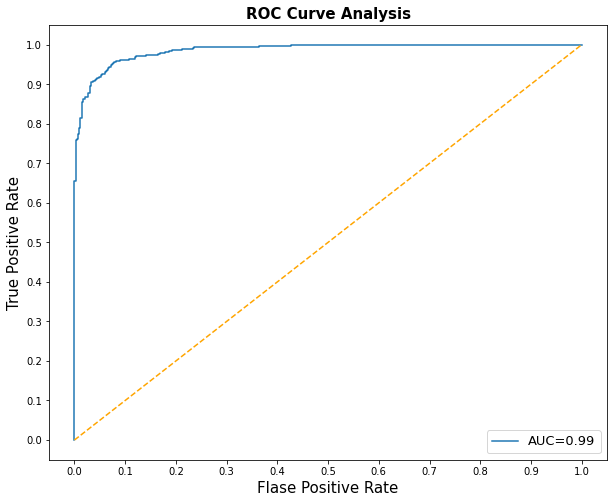

In [99]:
fpr, tpr, _ = metrics.roc_curve(sim_dat['y'].values, p_prob[:,1])

fig = plt.figure(figsize=(10,8))

plt.plot(fpr.tolist(), tpr.tolist(),  label="AUC={:.2f}".format(auc))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Group lasso logistic regression

The `pyglmnet` package can apply group lasso regularization.

In [101]:
!pip install pyglmnet

In [102]:
from pyglmnet import GLMCV
from pyglmnet.datasets import fetch_group_lasso_datasets
import matplotlib.pyplot as plt

In [132]:
# get predictors and responses
trainx = sim_dat.drop(columns = ['y'])

# get group index
names = trainx.columns.to_list()
trainx = trainx.values
group_idxs = [int(names[i][1]) for i in range(len(names))]
group_idxs[:10]

trainy = sim_dat['y'].values
# change data type from 'int' to 'bool'
trainy = trainy == 1

In [140]:
# set up the group lasso GLM model
gl_glm = GLMCV(distr="binomial", tol=1e-3,
               group=group_idxs, score_metric="deviance",
               alpha=1.0, max_iter=100, cv=10, verbose=True)
print("gl_glm: ", gl_glm)

gl_glm:  <
Distribution | binomial
alpha | 1.00
max_iter | 100.00
lambda: 0.50 to 0.01
>


In [136]:
# predict probability
ypred_prob = gl_glm.predict_proba(trainx)

In [139]:
# check auc
auc = metrics.roc_auc_score(sim_dat['y'].values, ypred_prob)
auc 

0.9529260651629073